In [ ]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.api import OLS, add_constant
from statsmodels.api import qqplot
from statsmodels.stats.diagnostic import het_breuschpagan

# 分类数据建模2

## 概述

本 Jupyter Notebook 主要探索如何在建模中研究交互项的影响。我们将使用一个简单的两级分类数据（性别）来建模男性和女性的收入与年龄关系。

## 生成数据

我们将使用以下函数生成合成数据，从而为男性和女性群体生成不同的收入值。

In [16]:
def generate_data(N, interaction=False):
    """
    Generate a DataFrame with synthetic data.

    Parameters
    ----------
    N : int
        The number of rows to generate in the DataFrame.

    Returns
    -------
    pd.DataFrame
        A DataFrame containing `N` rows with columns for Age, Gender, and Income.

    Notes
    -----
    - Ages are randomly generated integers between 20 and 60.
    - Genders are randomly assigned as either 'Male' or 'Female'.
    - Income is calculated as a base value plus an amount that depends on
      age and gender, with some random noise added for realism.
    - Gender is encoded such that 'Male' has an additional income boost.
    """
    np.random.seed(0)  # For reproducibility
    ages = np.random.randint(20, 60, size=N)
    genders = np.random.choice(["Male", "Female"], size=N)
    incomes = (
        30000
        + ages * 1000
        + (genders == "Female") * 5000
        + np.random.normal(0, 5000, N)
    )
    if interaction:
        incomes += (genders == "Female") * ages * 2000

    df = pd.DataFrame({"Age": ages, "Gender": genders, "Income": incomes})
    return df

In [17]:
N = 500
data = generate_data(N, interaction=True)

## 数据可视化

我们将从绘制数据的散点图开始，以初步观察数据特征。

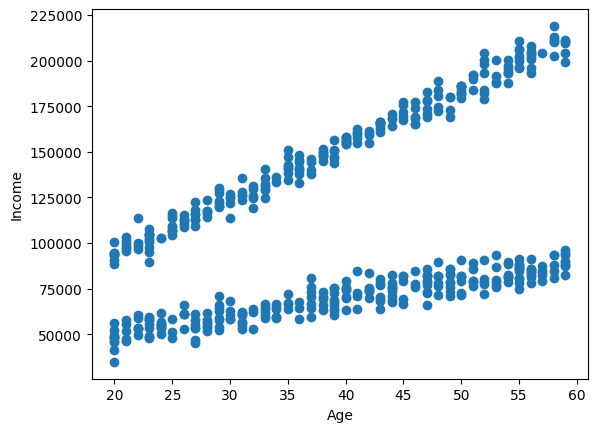

In [18]:
plt.scatter(data["Age"], data["Income"])
plt.xlabel("Age")
plt.ylabel("Income")
plt.show()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.190
Method:                 Least Squares   F-statistic:                     117.7
Date:                Mon, 04 Nov 2024   Prob (F-statistic):           9.34e-25
Time:                        01:27:15   Log-Likelihood:                -6048.7
No. Observations:                 500   AIC:                         1.210e+04
Df Residuals:                     498   BIC:                         1.211e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.799e+04   6811.546      5.578      0.0

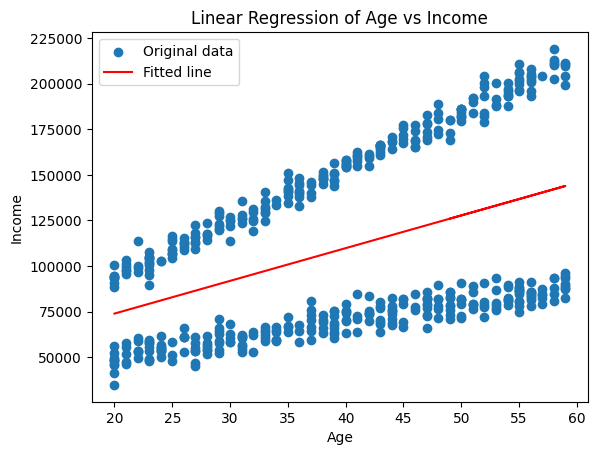

In [19]:
x = data["Age"].values.reshape(-1, 1)
y = data["Income"].values

x_with_intercept = add_constant(x)
model = OLS(y, x_with_intercept)
results = model.fit()
print(results.summary())

income_pred = results.predict(x_with_intercept)

plt.scatter(x, y, label="Original data")
plt.plot(x, income_pred, color="red", label="Fitted line")
plt.xlabel("Age")
plt.ylabel("Income")
plt.title("Linear Regression of Age vs Income")
plt.legend()
plt.show()

让我们再次查看散点图。这次，我们将使用不同颜色绘制不同性别的数据点。

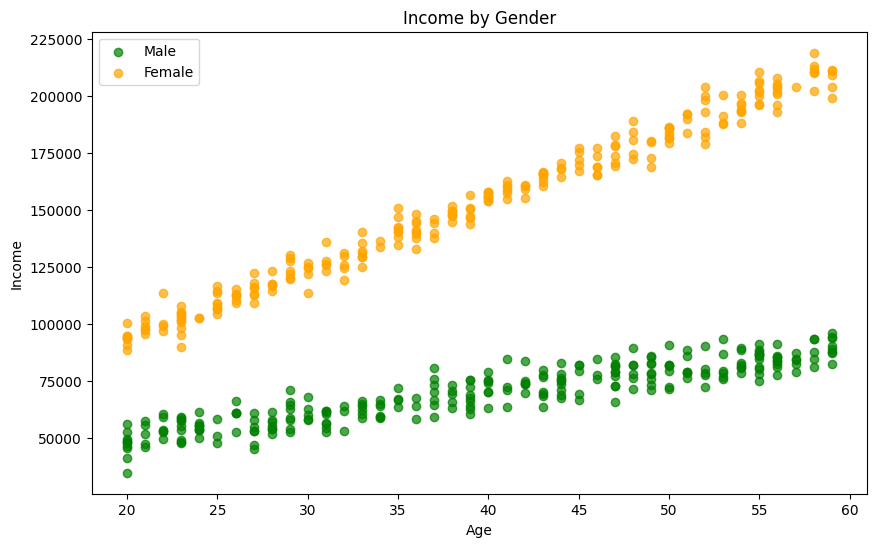

In [20]:
plt.figure(figsize=(10, 6))
colours = {"Male": "g", "Female": "orange"}
for gender in data["Gender"].unique():
    subset = data[data["Gender"] == gender]
    plt.scatter(
        subset["Age"],
        subset["Income"],
        label=f"{gender}",
        color=colours[gender],
        alpha=0.7,
    )

plt.title("Income by Gender")
plt.xlabel("Age")
plt.ylabel("Income")
plt.legend()
plt.show()

我们现在将尝试调整性别因素，并恢复 `generate_data()` 函数中使用的原始模型。首先，我们将使用 `pandas.get_dummies()` 函数将分类数据替换为二进制（$0$ 或 $1$）数据。此外，我们将使用 `drop_first` 选项，用单个变量（而不是两个）来表示 `Gender`。当值为零时表示女性，为一时表示男性。至于将哪个类别赋值为零或一并不重要，可以作为一个单独的练习来验证。

In [21]:
data_encoded = pd.get_dummies(data, columns=["Gender"], drop_first=True)
print(data_encoded.head())

   Age         Income  Gender_Male
0   20   49771.480197         True
1   23  105102.538279        False
2   23   47850.323583         True
3   59   87250.283177         True
4   29  127501.421691        False


In [22]:
x = data_encoded[["Age", "Gender_Male"]]
y = data_encoded["Income"]

x_with_intercept = add_constant(np.asarray(x, dtype=float))
model = OLS(y, x_with_intercept)
results = model.fit()
print(results.summary())
beta_0_hat, beta_1_hat, beta_2_hat = results.params
income_pred = results.predict(x_with_intercept)

print(rf"$\beta_2$ (Gender_Male): {beta_2_hat}")
print(rf"$\beta_1$ (Age): {beta_1_hat}")
print(rf"$\beta_0$: {beta_0_hat}")

                            OLS Regression Results                            
Dep. Variable:                 Income   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     3292.
Date:                Mon, 04 Nov 2024   Prob (F-statistic):          1.96e-287
Time:                        01:27:15   Log-Likelihood:                -5437.5
No. Observations:                 500   AIC:                         1.088e+04
Df Residuals:                     497   BIC:                         1.089e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.624e+04   2076.938     36.708      0.0

拟合模型为

$$
\hat y = \beta^T x = \beta_0 + \beta_1 x_{age} + \beta_2 x_{gender}
$$

其中，$\beta_0$ 表示截距，$x_{gender}$ 是一个二进制数。该模型对不同性别预测的行为如下：

$$
\hat y_{female} = \beta_0 + \beta_1 x_{age}
$$

和

$$
\hat y_{male} = (\beta_0 + \beta_2) + \beta_1 x_{age}
$$

这意味着，两个性别的收入可以通过相同的趋势（斜率）来预测，但基线有所不同。接下来我们将可视化结果。

更接近 1 的值表示模型解释了因变量方差的较大比例。然而，如果观测值较少或预测变量过多，结果可能具有误导性，此时调整后的 $R^2$ 可以提供帮助。

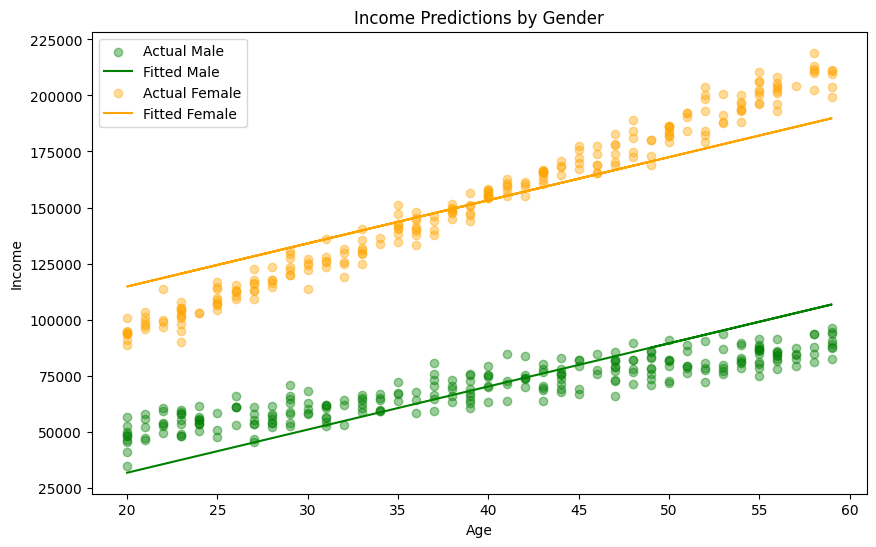

In [23]:
y_pred = results.predict(x_with_intercept)
data["Predicted_Income"] = y_pred

# Plot
plt.figure(figsize=(10, 6))
for gender in data["Gender"].unique():
    subset = data[data["Gender"] == gender]
    plt.scatter(
        subset["Age"],
        subset["Income"],
        label=f"Actual {gender}",
        color=colours[gender],
        alpha=0.4,
    )
    plt.plot(
        subset["Age"],
        subset["Predicted_Income"],
        label=f"Fitted {gender}",
        color=colours[gender],
    )

plt.title("Income Predictions by Gender")
plt.xlabel("Age")
plt.ylabel("Income")
plt.legend()  # Adding legend
plt.show()

现在我们将添加一个交互项：

$$
\hat y = \beta_0 + \beta_1 \cdot x_{age} + \beta_2 \cdot x_{gender} + \beta_3 \cdot x_{gender} \cdot x_{age}
$$

其中，$\beta_0$ 表示截距，$x_{gender}$ 是一个二进制数。该模型对不同性别的预测行为如下：

$$
\hat y_{female} = \beta_0 + \beta_1 x_{age}
$$

和

$$
\hat y_{male} = (\beta_0 + \beta_2) + (\beta_1 + \beta_3) x_{age}
$$

这意味着，两个性别的收入**不能**通过相同的趋势（斜率）来预测，且基线也存在差异。接下来我们将可视化结果。

                            OLS Regression Results                            
Dep. Variable:                 Income   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                 1.582e+04
Date:                Mon, 04 Nov 2024   Prob (F-statistic):               0.00
Time:                        01:27:15   Log-Likelihood:                -4958.8
No. Observations:                 500   AIC:                             9926.
Df Residuals:                     496   BIC:                             9942.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.394e+04   1122.499     30.240      0.0

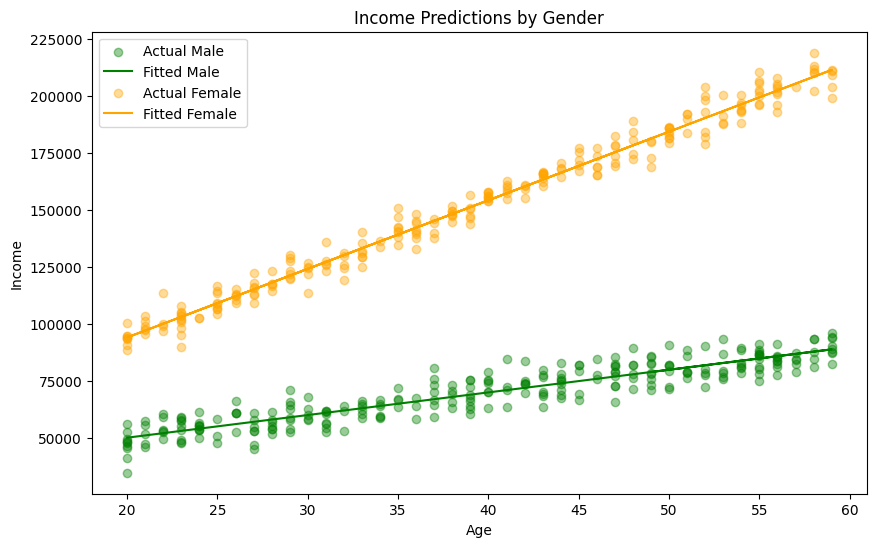

In [24]:
x = data_encoded[["Age", "Gender_Male"]]
x["Age:Male"] = x["Age"] * x["Gender_Male"]
y = data_encoded["Income"]

x_with_intercept = add_constant(np.asarray(x, dtype=float))
model = OLS(y, x_with_intercept)
results = model.fit()
print(results.summary())
beta_0_hat, beta_1_hat, beta_2_hat, beta_3_hat = results.params
income_pred = results.predict(x_with_intercept)

print(rf"$\beta_3$ (Age:Male): {beta_3_hat:.4}")
print(rf"$\beta_2$ (Gender_Male): {beta_2_hat:.4}")
print(rf"$\beta_1$ (Age): {beta_1_hat:.4}")
print(rf"$\beta_0$: {beta_0_hat:.4}")
print(rf"$\beta_0+\beta_2$: {beta_0_hat+beta_2_hat:.4}")
print(rf"$\beta_1+\beta_3$: {beta_1_hat+beta_3_hat:.4}")


y_pred = results.predict(x_with_intercept)
data["Predicted_Income"] = y_pred

# Plot
plt.figure(figsize=(10, 6))
for gender in data["Gender"].unique():
    subset = data[data["Gender"] == gender]
    plt.scatter(
        subset["Age"],
        subset["Income"],
        label=f"Actual {gender}",
        color=colours[gender],
        alpha=0.4,
    )
    plt.plot(
        subset["Age"],
        subset["Predicted_Income"],
        label=f"Fitted {gender}",
        color=colours[gender],
    )

plt.title("Income Predictions by Gender")
plt.xlabel("Age")
plt.ylabel("Income")
plt.legend()  # Adding legend
plt.show()

运用迄今为止学到的技能来评估模型的拟合优度，并根据零假设对其进行检验。

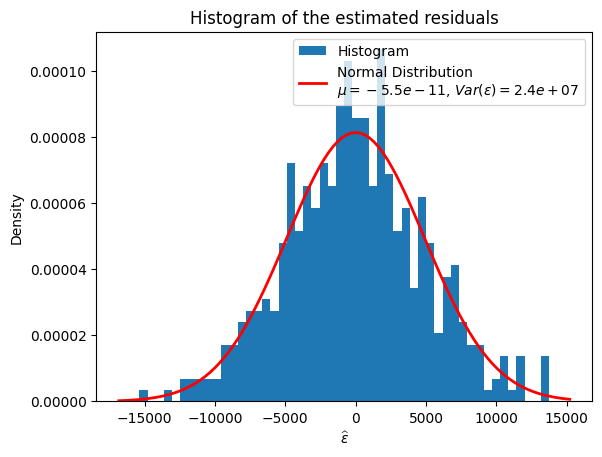

In [25]:
estimated_residuals = results.resid

plt.hist(estimated_residuals, bins=50, density=True, label="Histogram")
xmin, xmax = plt.xlim()

mean, std_dev = np.mean(estimated_residuals), np.std(estimated_residuals)
x_normal = np.linspace(xmin, xmax, 100)
p = scipy.stats.norm.pdf(x_normal, mean, std_dev)

plt.plot(
    x_normal,
    p,
    "r",
    linewidth=2,
    label="Normal Distribution\n"
    rf"$\mu={mean:.2}$, $Var(\varepsilon)={np.var(estimated_residuals):.2}$",
)

plt.legend()
plt.title("Histogram of the estimated residuals")
plt.xlabel(r"$\widehat\varepsilon$")
plt.ylabel("Density")
plt.show()

Shapiro-Wilk Test: 
W-statistic=0.998, 
p-value=0.857

It is a normal distribution



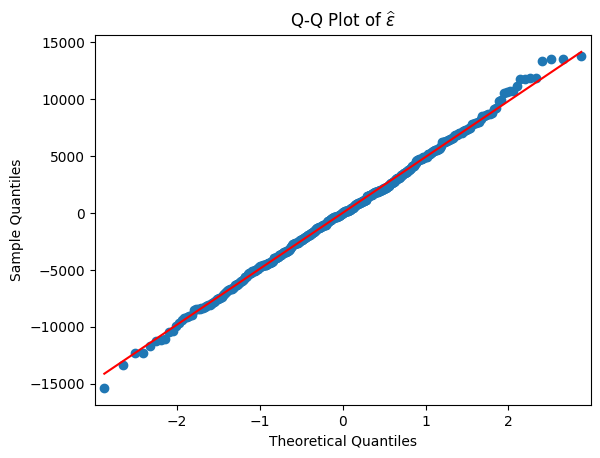

In [ ]:
qqplot(estimated_residuals, line="s")
plt.title(r"Q-Q Plot of $\widehat\varepsilon$")
shapiro_test = scipy.stats.shapiro(estimated_residuals)
print(
    f"Shapiro-Wilk Test: \nW-statistic={shapiro_test.statistic:.3}, \np-value={shapiro_test.pvalue:.3}"
)
if shapiro_test.pvalue < 0.05:
    print("\nNot a normal distribution\n")
else:
    print("\nIt is a normal distribution\n")

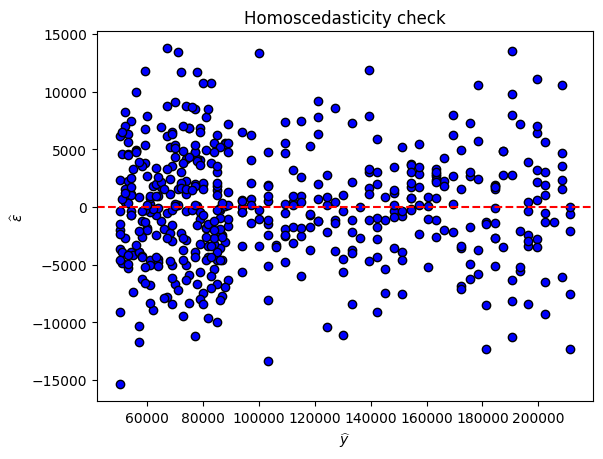

Lagrange multiplier statistic: 5.5655246068473385
p-value: 0.13477162608835586
f-value: 1.8610488968575292
f p-value: 0.1352370496948755

Homoscedasticity: The variance is constant

                            OLS Regression Results                            
Dep. Variable:                 Income   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                 1.582e+04
Date:                Mon, 04 Nov 2024   Prob (F-statistic):               0.00
Time:                        01:27:16   Log-Likelihood:                -4958.8
No. Observations:                 500   AIC:                             9926.
Df Residuals:                     496   BIC:                             9942.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std

In [ ]:
plt.scatter(y_pred, estimated_residuals, color="blue", edgecolor="k")
plt.axhline(y=0, color="red", linestyle="--")
plt.title("Homoscedasticity check")
plt.xlabel(r"$\widehat y$")
plt.ylabel(r"$\widehat\varepsilon$")
plt.show()

bp_test = het_breuschpagan(estimated_residuals, x_with_intercept)
labels = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test_results = dict(zip(labels, bp_test))

for k, v in test_results.items():
    print(f"{k}: {v}")

if test_results["f p-value"] < 0.05:
    print("\nHeteroscedasticity: The variance is NOT constant\n")
else:
    print("\nHomoscedasticity: The variance is constant\n")

print(results.summary())